The use of Tensorflow for drawing the Mandelbrot set is one of the basic demos as 
[tensorflow.org](https://www.tensorflow.org/tutorials/mandelbrot).

### Goal
To expand upon the demo from tensorflow.org I have made a few changes:
* Instead of a loop in python use Tensorflow's <code>while_loop</code>
* For generating the grid, using Tensorflow's <code>meshgrid</code> instead of numpy's <code>mgrid</code>
* Instead of using <code>PIL.Image</code>, use my favorite graphing of <code>matplotlib.pyplot</code>

### Basic Graphing
The first part of this will just show a generating a grid and graphing a simple function using numpy's <code>mgrid</code>.

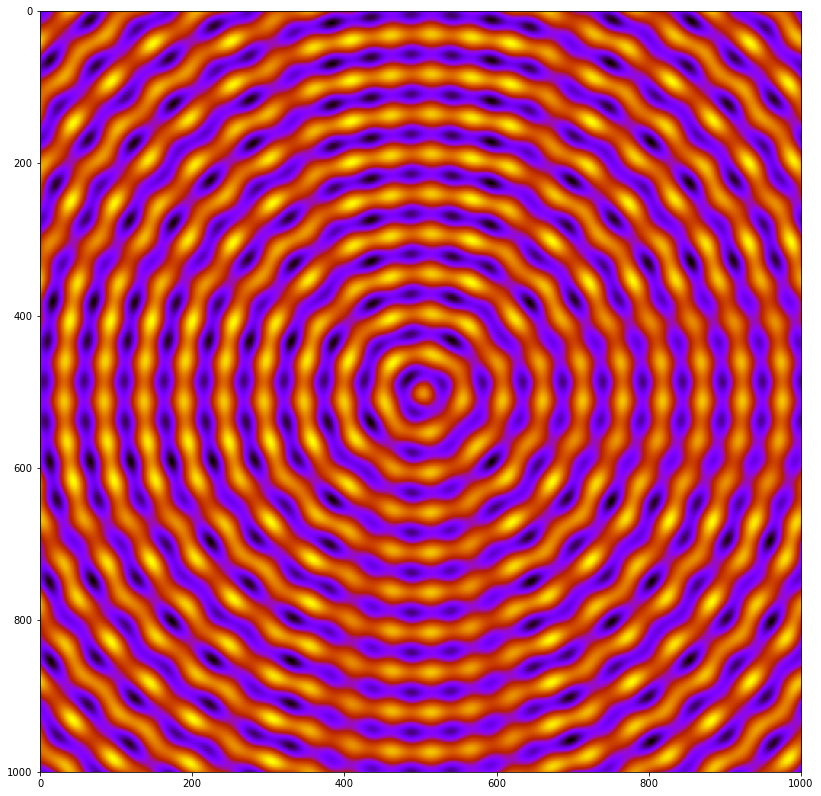

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def complex_grid_np(x_min, x_max, y_min, y_max, steps):
    """ Use the numpy approach to generate a grid of complex numbers
    """
    dx = (x_max-x_min) / steps
    dy = (y_max-y_min) / steps
    Y, X = np.mgrid[x_min: x_max: dx, y_min: y_max: dy]
    return X + 1j*Y

def draw_data(count_grid):
    """ Draws an image based on the supplied numpy array
    """
    # For more color choices: https://matplotlib.org/examples/color/colormaps_reference.html
    plt.gcf().set_size_inches(14, 14)
    plt.imshow(count_grid, cmap='gnuplot')
    plt.show()

resolution = 1000
data = complex_grid_np(-2, 2, -2, 2, resolution)
counts = (3*np.sin(data.real*30) + 3*np.sin(data.imag*30) + 10*np.cos(30*np.absolute(data)))
draw_data(counts)

### Mandelbrot Graphing
This defines a function for generating the grid using tensorflow.meshgrid instead of the numpy approach

Then the approach from tensorflow.org is used to graph the mandelbrot set.

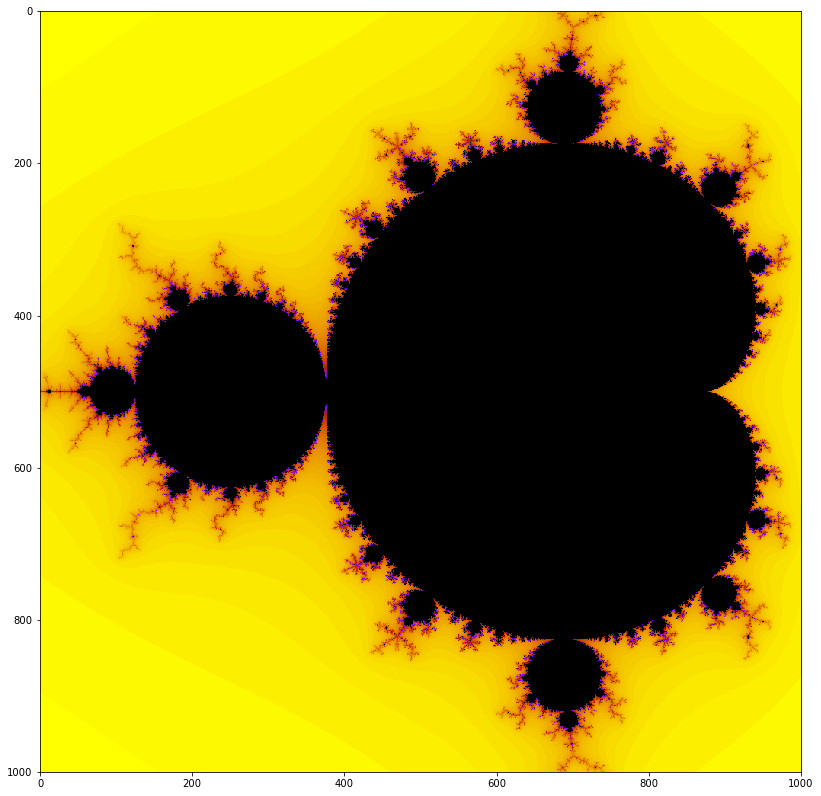

In [2]:
def complex_grid_tf(x_min, x_max, y_min, y_max, steps):  
    """ Use the Tensorflow approach to generate a grid of compelx numbers
    """
    dx = (x_max-x_min) / steps
    dy = (y_max-y_min) / steps
    X, Y = tf.meshgrid(tf.range(y_min, y_max, dy), tf.range(x_min, x_max, dx))
    Z = tf.complex(X, Y)
    return Z

xs = complex_grid_tf(-1, 1, -1.5, 0.5, resolution)

# The following logic is almost identical to the Mandelbrot demonstration from tensorflow.org
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.float32))
zs_ = zs*zs + xs

not_diverged = tf.abs(zs_) < 4

step = tf.group(
  zs.assign(zs_),
  ns.assign_add(tf.cast(not_diverged, tf.float32))
)

max_count = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_count): 
        step.run()
    draw_data(sess.run(max_count-ns))

### Mandelbrot Graphing with tensorflow.while_loop
Instead of doing the looping in python, the following code use the while_loop of tensorflow.

In this approach, the code is more efficient and perhaps even slightly more readable.

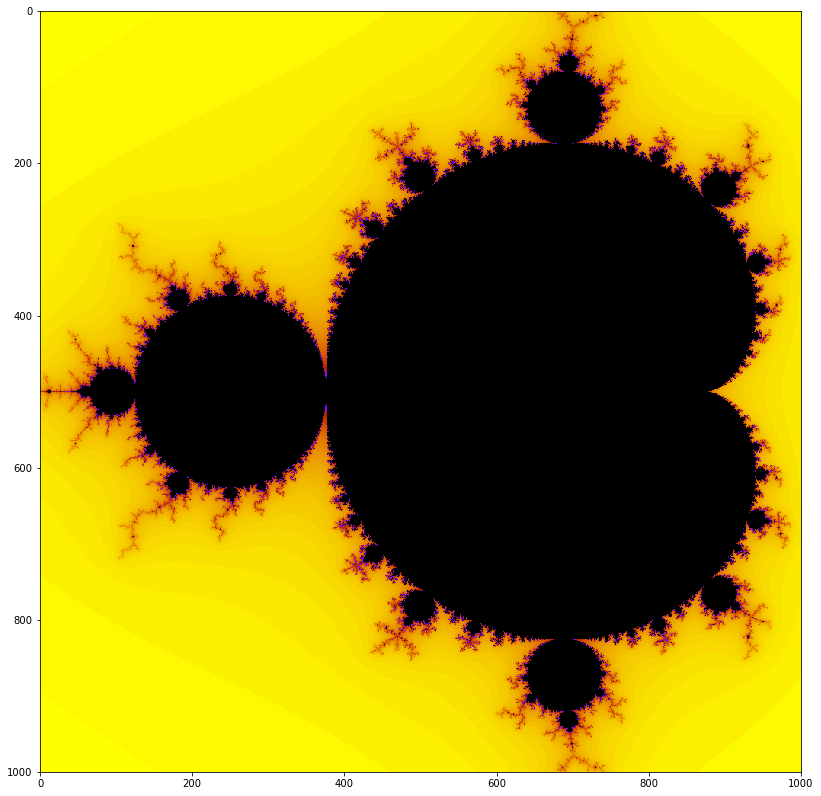

In [3]:
xs = complex_grid_tf(-1, 1, -1.5, 0.5, resolution) 
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.int32))

max_count = 100
i = tf.constant(0)
c = lambda i, zs, ns: i < max_count
b = lambda i, zs, ns: (i+1, zs*zs + xs, ns + tf.cast(tf.abs(zs) < 4, tf.int32))
r = tf.while_loop(c, b, [i, zs, ns])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ns_np = sess.run(max_count-r[2])  # the second index relates to the variable ns which is what we want to graph
    draw_data(ns_np)